# Composing and taking gradients of neurons and layers.

We show how to construct neurons, layers and neural nets by composing scalar multiplications, bias, copy and merge. See arxiv:1711.10455.

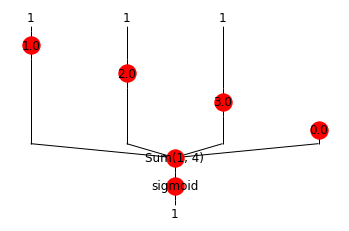

In [17]:
from discopy.learner import np, Neuron, Layer

weights = np.array([1., 2., 3., 0.])
Neuron(3, weights).draw()

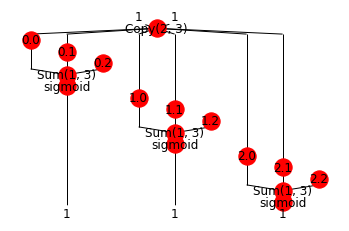

In [18]:
params = [[0.0, 0.1, 0.2], [1.0, 1.1, 1.2], [2.0, 2.1, 2.2]]
Layer(2, 3, params).draw()

We can jit and take the gradient of neurons and layers using Jax.

In [20]:
import jax.numpy as np
from jax import jit, grad

print(jit(Neuron(3, weights))(np.array([1.2, 0.3, 1.2])))
print(grad(lambda x: Neuron(3, weights)(x)[0])(np.array([1.2, 0.3, 1.2])))

[0.9955037]
[0.00447606 0.00895211 0.01342817]


In [24]:
print(jit(Layer(2, 3, params))(np.array([1.2, 0.3])))
print(grad(lambda x: Layer(2, 3, params)(x)[2])(np.array([1.2, 0.3])))

[0.5572479 0.9387739 0.9946749]
[0.01059332 0.01112298]
